# Healthcare Dataset Challenge EDA

by Rebecca Lim

--- 
### Task:  
Analyze the clinical and financial data of patients hospitalized for a certain condition.   
Join the data given in different tables, and find insights about the drivers of cost of care.

### Background:

Likely drivers of healthcare costs based on research:
- Unit prices 
- Administrative costs
- Technology
- Inflation
- Inefficient system performance
- Aging population

However, dataset does not provide much data relating to above factors. 
Instead dataset provides patient specific clinical data, medical history and demographics.
Objective is likely to be more patient specific than identifying systemic drivers of healthcare cost.  

### Target Feature: 
- amount (bill/invoice)  

### Objective:  
- Identify risk factors that might incur higher cost.  
- May be used by insurance companies to predict high risk individuals for the formulation of payment strategies

# 1) Load & Join Dataset

In [201]:
# Data Manipulation 
import pandas as pd
import numpy as np
import math

# Data Visualization
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Customizations
sns.set(font_scale=1.5)
colors = ['#7a7a74','#dadace','#ece9e1','#a5a59c']
customPalette = sns.set_palette(sns.color_palette(colors))
plt.style.use('seaborn-whitegrid')

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [15]:
# Load data tables from CSV
pathname = 'data'
bill_am = pd.read_csv( pathname +'/bill_amount.csv')
bill_id = pd.read_csv( pathname +'/bill_id.csv')
clin_da = pd.read_csv( pathname +'/clinical_data.csv')
demogra = pd.read_csv( pathname +'/demographics.csv')

In [16]:
# View size of data given
df_names = ['bill_amount', 'bill_id', 'clinical_data', 'demographics']
df_shapes = [df.shape for df in [bill_am, bill_id, clin_da, demogra]]
pd.DataFrame(df_shapes,df_names)

0   1
bill_amount    13600   2
bill_id        13600   3
clinical_data   3400  26
demographics    3000   5

In [17]:
# View feature names given in each table
for df in [bill_am, bill_id, clin_da, demogra]:
    print(df.columns)

Index(['bill_id', 'amount'], dtype='object')
Index(['bill_id', 'patient_id', 'date_of_admission'], dtype='object')
Index(['id', 'date_of_admission', 'date_of_discharge', 'medical_history_1',
       'medical_history_2', 'medical_history_3', 'medical_history_4',
       'medical_history_5', 'medical_history_6', 'medical_history_7',
       'preop_medication_1', 'preop_medication_2', 'preop_medication_3',
       'preop_medication_4', 'preop_medication_5', 'preop_medication_6',
       'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5',
       'lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height'],
      dtype='object')
Index(['patient_id', 'gender', 'race', 'resident_status', 'date_of_birth'], dtype='object')


## Observations

From the table shapes and column names, we can see that:
- bill_amount.csv records the bill amount (target variable) for each bill ID 
- bill_id.csv records the ID of bills charged to patients for each admission  
    -> both have the same amount of data entries   
    -> together they record the amount paid for all bills/invoices incurred by patients on different dates of admission   
    
     
- clinical_data.csv records the clinical findings of patient at each hospital admission.   
- demographics.csv records the demographic data for each patient  
    -> theres only 3000 unique patients but 3400 admissions  
    -> some patients had repeated hospital admissions  
  
There is exactly 4 times the no. of bill IDs to admissions.  
This means that for each admission, the patient is likely to be charged 4 invoices (likely separate charges for bed, food, medical supplies and services, and any tests or procedures)   
Merge data and prioritize billing data


In [18]:
# Merge tables with bill data - Only data with bill amount required

billing_data = bill_am.merge(bill_id, on='bill_id',how = 'left').sort_values(by=['date_of_admission','patient_id'])
billing_data

bill_id        amount                        patient_id  \
1236   7654730355   1133.601902  1d21f2be18683991eb93d182d6b2d220   
3497   7512568183  12338.269972  1d21f2be18683991eb93d182d6b2d220   
7838   1692196063    982.332324  1d21f2be18683991eb93d182d6b2d220   
11796  7968360812    951.214467  1d21f2be18683991eb93d182d6b2d220   
1193   3762633379   1145.372193  62bdca0b95d97e99e1c712048fb9fd09   
...           ...           ...                               ...   
10755  1641053864   1047.298193  a4c61deaa9ce86b4d2289eab6128b872   
2705   7092335187    502.668346  ac52a32f8ce8c46d82df2d72052ae5a9   
9595   6956955826   2729.043717  ac52a32f8ce8c46d82df2d72052ae5a9   
10651   861682644  16003.560307  ac52a32f8ce8c46d82df2d72052ae5a9   
11412  5953121381    906.139230  ac52a32f8ce8c46d82df2d72052ae5a9   

      date_of_admission  
1236         2011-01-01  
3497         2011-01-01  
7838         2011-01-01  
11796        2011-01-01  
1193         2011-01-01  
...                 ...  
10755        2015-12-28  
2705         2015-12-28  
9595         2015-12-28  
10651        2015-12-28  
11412        2015-12-28  

[13600 rows x 4 columns]

In [19]:
# Merge demographic data to clinical data

patient_data = clin_da.merge(demogra, left_on='id',right_on='patient_id',how = 'left').sort_values(by=['date_of_admission','id'])
patient_data.drop('patient_id',axis =1,inplace= True)
print(f'Shape of combined patient data: {patient_data.shape}')


Shape of combined patient data: (3400, 30)


In [20]:
# Merge Patient and Billing data on patient_id and date_of_admission

full_data = pd.merge(billing_data, patient_data,  how='left', left_on=['patient_id','date_of_admission'], right_on = ['id','date_of_admission']).sort_values(by=['date_of_admission','id'])
full_data.drop('id',axis =1,inplace= True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 0 to 13599
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bill_id             13600 non-null  int64  
 1   amount              13600 non-null  float64
 2   patient_id          13600 non-null  object 
 3   date_of_admission   13600 non-null  object 
 4   date_of_discharge   13600 non-null  object 
 5   medical_history_1   13600 non-null  int64  
 6   medical_history_2   12668 non-null  float64
 7   medical_history_3   13600 non-null  object 
 8   medical_history_4   13600 non-null  int64  
 9   medical_history_5   12384 non-null  float64
 10  medical_history_6   13600 non-null  int64  
 11  medical_history_7   13600 non-null  int64  
 12  preop_medication_1  13600 non-null  int64  
 13  preop_medication_2  13600 non-null  int64  
 14  preop_medication_3  13600 non-null  int64  
 15  preop_medication_4  13600 non-null  int64  
 16  preo

# 2) Data Profiling

Get an preliminary overview to identify columns with missing or erroneous data for the purposes of data cleaning and feature engineering

In [61]:
df = full_data.copy()

# Change dtype of dates to datetime 
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])
df['date_of_discharge'] = pd.to_datetime(df['date_of_discharge'])
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])

In [22]:
# Install and generate a profile report using Pandas profiling. 
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", progress_bar=True, minimal=True, explorative=True) 

# Summary and Insights from Pandas profiling
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3) Data Cleaning 

## Handle Erroneous Data:
Correct errors from mistakes during data entry

| Feature Name | Corrections to make  | 
| :--- | :--- |
| **Medical History 3** |  <ul><li>'Yes' to '1'</li><li>'No' to '0'</li></ul>|
| **Gender** | <ul><li>'m' to 'male'</li><li>'f' to 'female'</li></ul> |
| **Race** | <ul><li>'chinese' to 'Chinese' </li><li>'India' to 'Indian'</li></ul> |
| **Resident Status** | <ul><li>'Singapore Citizen' to 'Singaporean'</li></ul> |


/Users/Rebecca1/opt/anaconda3/envs/environ1/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


medical history 3 dtype: int64


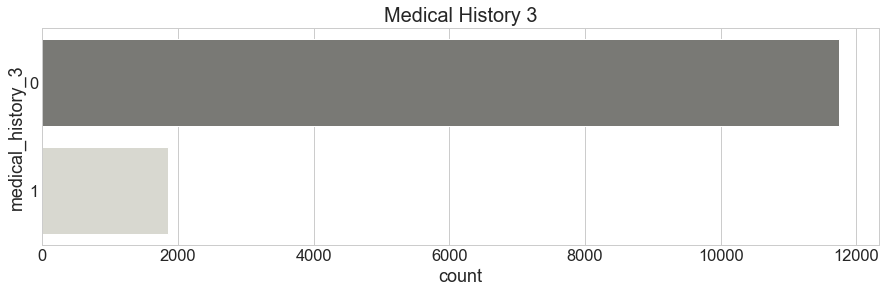

In [62]:
# Medical History 3: Encode 'Yes' to '1' and 'No' to '0'
df.loc[df['medical_history_3'] == 'Yes', 'medical_history_3'] = '1'
df.loc[df['medical_history_3'] == 'No', 'medical_history_3'] = '0'
df = df.astype({'medical_history_3': 'int64'})

plt.figure(figsize=(15,4)) 
sns.countplot(y="medical_history_3", data= df);
plt.title('Medical History 3',fontsize=20);

print(f'medical history 3 dtype: {df.medical_history_3.dtypes}')

Gender dtype: object


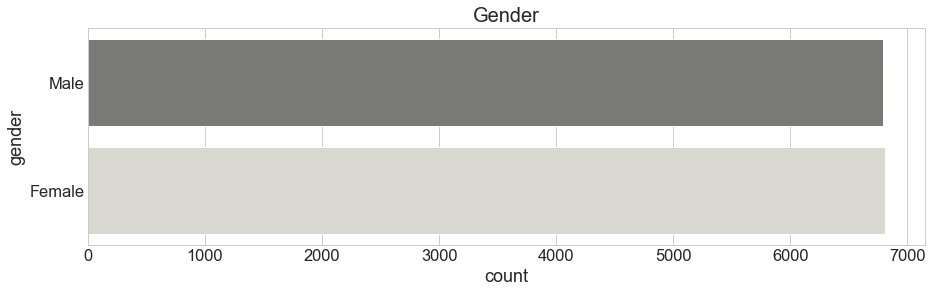

In [63]:
# Gender: Correct 'm' to 'Male' and 'f' to 'Female'
df.loc[full_data['gender'] == 'm', 'gender'] = 'Male'
df.loc[full_data['gender'] == 'f', 'gender'] = 'Female'

plt.figure(figsize=(15,4)) 
sns.countplot(y="gender", data= df);
plt.title('Gender',fontsize=20);
print(f'Gender dtype: {df.gender.dtypes}')

Race dtype: object


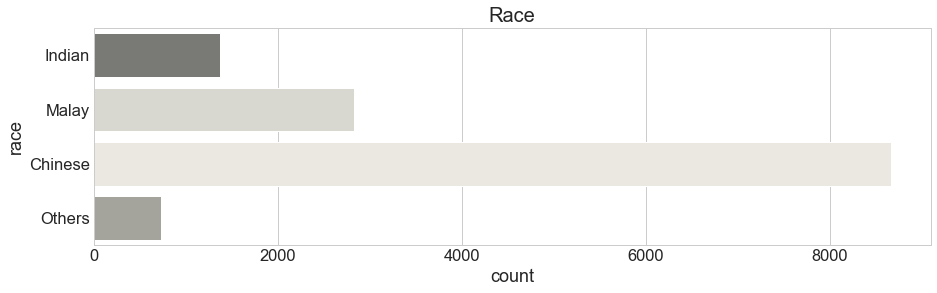

In [64]:
# Race: Correct 'chinese' to 'Chinese' & 'India' to 'Indian'
df.loc[full_data['race'] == 'chinese', 'race'] = 'Chinese'
df.loc[full_data['race'] == 'India', 'race'] = 'Indian'

plt.figure(figsize=(15,4)) 
sns.countplot(y="race", data= df);
plt.title('Race',fontsize=20);
print(f'Race dtype: {df.race.dtypes}')

Resident Status dtype: object


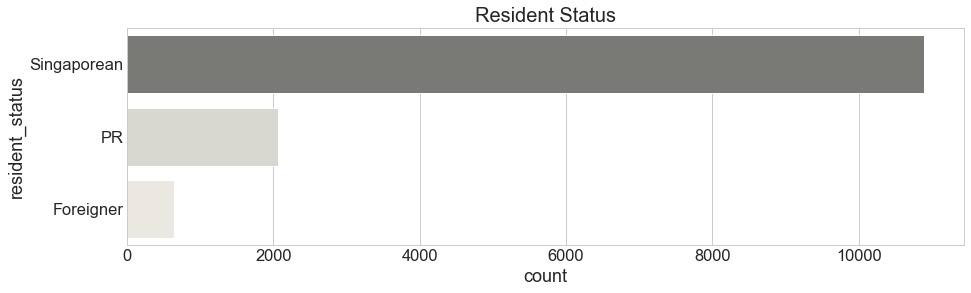

In [65]:
# Resident Status: Correct 'Singapore Citizen' to 'Singaporean'
df.loc[df['resident_status'] == 'Singapore citizen', 'resident_status'] = 'Singaporean'

plt.figure(figsize=(15,4)) 
sns.countplot(y="resident_status", data= df);
plt.title('Resident Status',fontsize=20);
print(f'Resident Status dtype: {df.resident_status.dtypes}')


## Handle Missing Data:  
1. Medical History 2 (6.9%)
2. Medical History 5 (8.9%)  

    - More than 5% missing -> Too many to drop missing rows, too little to drop column 
    - Assuming that the data taken direct from EHR, it's likely that the staff forgot to enter data as the medical history was not present in the patient
    - Impute missing values with '0'(mode)
      

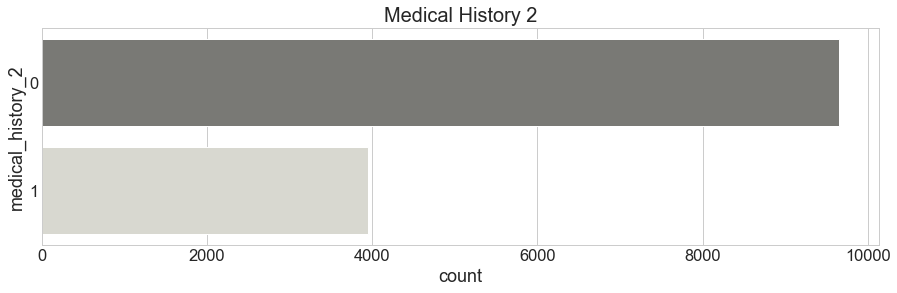

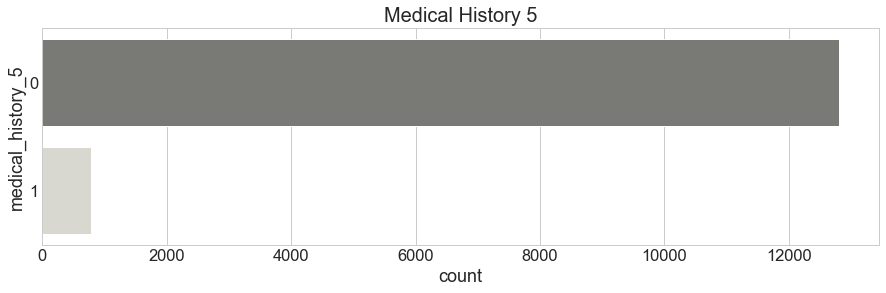

In [66]:
# Medical History 2,5: Impute NaN for '0'

# Medical History 3: Encode 'Yes' to '1' and 'No' to '0'
df['medical_history_2'].fillna(value='0', inplace=True)
df['medical_history_5'].fillna(value='0', inplace=True)

df = df.astype({'medical_history_2': 'int64'})
df = df.astype({'medical_history_5': 'int64'})

plt.figure(figsize=(15,4)) 
sns.countplot(y="medical_history_2", data= df);
plt.title('Medical History 2',fontsize=20);
plt.figure(figsize=(15,4)) 
sns.countplot(y="medical_history_5", data= df);
plt.title('Medical History 5',fontsize=20);

In [67]:
# Check that all missing values are cleaned
df.isna().any()

bill_id               False
amount                False
patient_id            False
date_of_admission     False
date_of_discharge     False
medical_history_1     False
medical_history_2     False
medical_history_3     False
medical_history_4     False
medical_history_5     False
medical_history_6     False
medical_history_7     False
preop_medication_1    False
preop_medication_2    False
preop_medication_3    False
preop_medication_4    False
preop_medication_5    False
preop_medication_6    False
symptom_1             False
symptom_2             False
symptom_3             False
symptom_4             False
symptom_5             False
lab_result_1          False
lab_result_2          False
lab_result_3          False
weight                False
height                False
gender                False
race                  False
resident_status       False
date_of_birth         False
dtype: bool

# 4) Feature Engineering

## 4.1) Target Feature: total_bill
  
Aggregate individual bill amounts to obtain total cost for each person per admission

In [72]:
# Total Bill: Aggregate bill for patient ID and visit
agg_data = df.copy()
agg_data= agg_data.groupby(['patient_id','date_of_admission']).agg({'amount':'sum'}).sort_values(by='date_of_admission')
agg_data = agg_data.rename(columns={'amount':'total_bill'})
display(agg_data.head())
data = pd.merge(df,agg_data, how='left', on=['patient_id','date_of_admission']).sort_values(by=['date_of_admission','patient_id'])
data = data.drop(['amount','bill_id'],axis=1).drop_duplicates()
data.info()

total_bill
patient_id                       date_of_admission              
62bdca0b95d97e99e1c712048fb9fd09 2011-01-01         23303.000924
1d21f2be18683991eb93d182d6b2d220 2011-01-01         15405.418665
79f52395dab0e6d3a03c48f765cb6562 2011-01-02         17153.905421
e0397dd72caf4552c5babebd3d61736c 2011-01-02         27994.878530
c85cf97bc6307ded0dd4fef8bad2fa09 2011-01-02         16813.123088

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 13596
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_admission   3400 non-null   datetime64[ns]
 2   date_of_discharge   3400 non-null   datetime64[ns]
 3   medical_history_1   3400 non-null   int64         
 4   medical_history_2   3400 non-null   int64         
 5   medical_history_3   3400 non-null   int64         
 6   medical_history_4   3400 non-null   int64         
 7   medical_history_5   3400 non-null   int64         
 8   medical_history_6   3400 non-null   int64         
 9   medical_history_7   3400 non-null   int64         
 10  preop_medication_1  3400 non-null   int64         
 11  preop_medication_2  3400 non-null   int64         
 12  preop_medication_3  3400 non-null   int64         
 13  preop_medication_4  3400 non-null   int64      

## 4.2) Feature Engineering - Predictors

### Remove Irrelevant Features
- Data that can be only collected after the admission has happened, cannot be used for predictions.  
eg. date_of_admission, date_of_discharge   
-> drop columns  
  

### Age
date_of_birth can be converted to age as of hospital admission 


In [74]:
#Age at hospitalisation: Date of Admission - Date of Birth

data['age'] = data['date_of_admission'].dt.year - data['date_of_birth'].dt.year
data[['date_of_admission','date_of_birth','age']].head()

date_of_admission date_of_birth  age
0         2011-01-01    1976-12-19   35
4         2011-01-01    1978-07-20   33
8         2011-01-02    1936-04-05   75
12        2011-01-02    1967-08-14   44
16        2011-01-02    1967-12-06   44

### BMI 
Condition might be related to relative mass instead of just height or weight

Body mass index = weight / (height * height) 

In [84]:
#BMI: kg/m2
data['bmi'] =  data['weight']/ ((data['height'])*(data['height'])) *10000
data[['weight','height','bmi']].head()

weight  height        bmi
0     71.3   161.0  27.506655
4     78.4   160.0  30.625000
8     92.8   176.0  29.958678
12    72.0   151.0  31.577562
16    64.4   152.0  27.873961

In [86]:
# Drop irrelevant features
data_clean = data.drop(['date_of_admission','date_of_discharge'],axis=1)

# 5) Visualizations 

## 5.1) Target Feature - total_bill

/Users/Rebecca1/opt/anaconda3/envs/environ1/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


median total bill: 20180.020614275498
mean total bill: 21859.071130380587
min total bill: 2946.100354358
max total bill: 98723.85499384


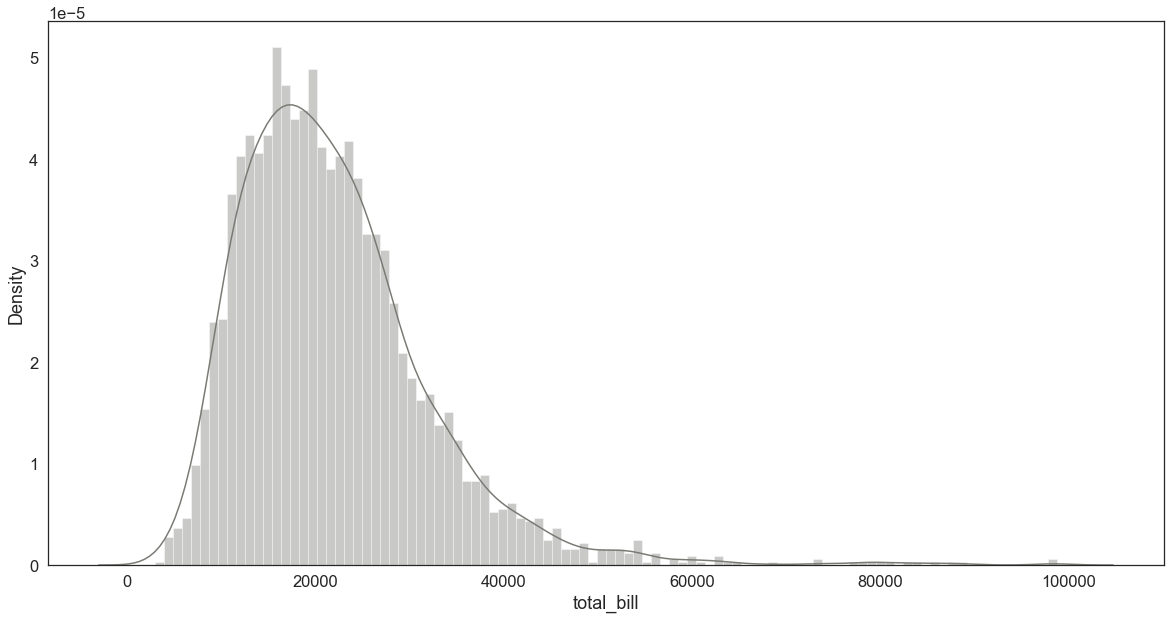

In [203]:
fig = plt.figure(figsize=(20,10))
sns.distplot(data_clean['total_bill'],bins=100)
print(f"median total bill: {data_clean['total_bill'].median()}")
print(f"mean total bill: {data_clean['total_bill'].mean()}")
print(f"min total bill: {data_clean['total_bill'].min()}")
print(f"max total bill: {data_clean['total_bill'].max()}")
plt.savefig('total_bill.png')

## Observations:

### Total Bill 

- central values for total bill ≈ \$20 000
- positively skewed, high kurtosis

# 5.2) Predictors
Visualize distribution for target feature in relation to other features

## Demographic Features

In [121]:
# Separate data by datatype
cat_cols = ['gender','race','resident_status']

clin_cols = ['medical_history_1', 'medical_history_2',
       'medical_history_3', 'medical_history_4', 'medical_history_5',
       'medical_history_6', 'medical_history_7', 'preop_medication_1',
       'preop_medication_2', 'preop_medication_3', 'preop_medication_4',
       'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2',
       'symptom_3', 'symptom_4', 'symptom_5']

num_cols = ['total_bill','lab_result_1', 'lab_result_2','lab_result_3', 'weight', 'height', 'bmi', 'age']


#cat_data = data_clean[cat_cols]
num_data = data_clean[num_cols]

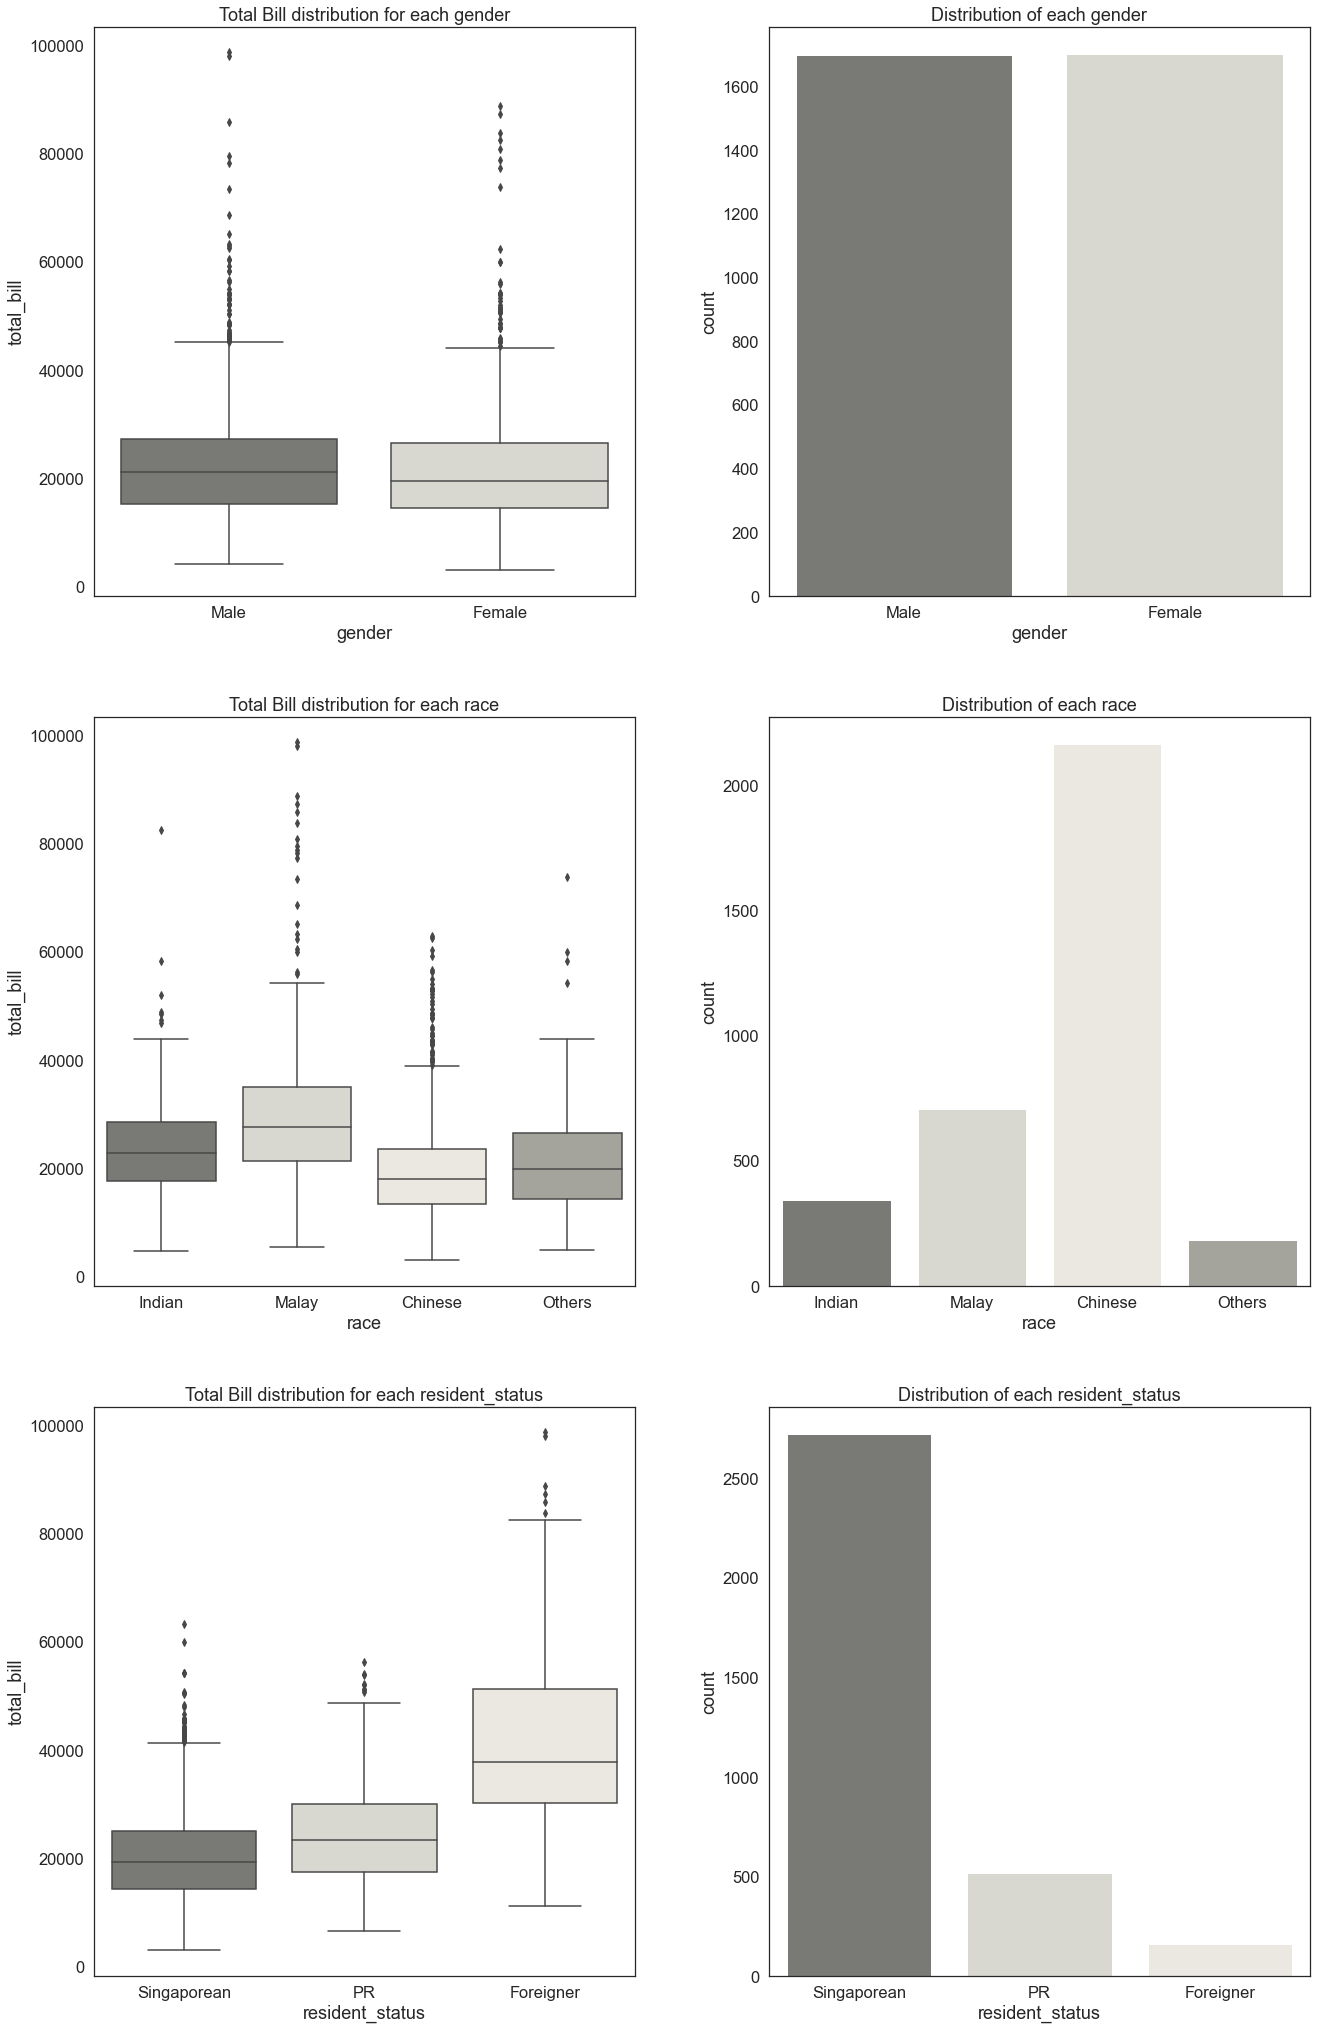

In [179]:
fig, axs = plt.subplots(len(cat_cols),2, figsize=(20,30))
fig.tight_layout(pad=5)

for i , col in enumerate(cat_cols):
    chart = sns.boxplot(x= col, data=data_clean, y='total_bill',ax=axs[i,0]);
    chart.set_title(f'Total Bill distribution for each {col}')
    chart1 = sns.countplot(x= col, data=data_clean,ax=axs[i,1]);
    chart1.set_title(f'Distribution of each {col}')

plt.savefig('cat_dist.png')

## Observations

### Gender

Distribution of male and females are quite equal
Total bill of males are slightly higher than that of females, may not be significant

### Race

Malay patients seem to be charged higher total bill amounts, followed by Indians, Others and Chinese patients.

### Resident Status

Foreigners are charged significantly much higher compared to PRs and Singaporeans. This could be due to different payment schemes/ choices in levels of care. Medical tourism may also be a factor.  

i'm curious if the differences in race are present in local population or if the differences are mainly from foreigners who happen to be of the same race, pulling the average up. 

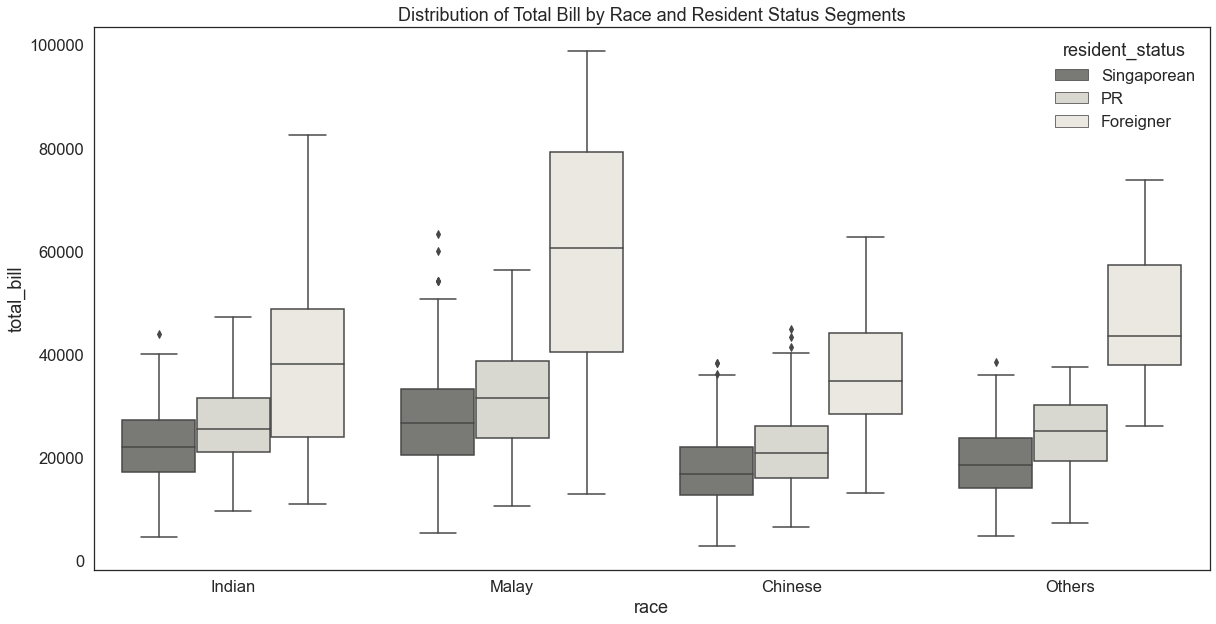

In [176]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-ticks')
fig = sns.boxplot(x= 'race', y='total_bill', data=data_clean, hue='resident_status')
fig.set_title(f'Distribution of Total Bill by Race and Resident Status Segments')
plt.savefig('race_res.png')

## Observations

It seems that my suspicions were correct.   
The foreign malay segment has the highest mean and range of bill amounts, which raised the mean of the Malay patients by a very signficant amount.   
The foreign patients who fall in the category of "Others" are the second highest paying segment.

The differences in bill amounts across races in local PR and Singaporean are much less pronounced, even though the overall trend (Malay, Indian, Others, Chinese) remains similar. 

-> Cross race and resident_status features to form 1 feature with 12 classes

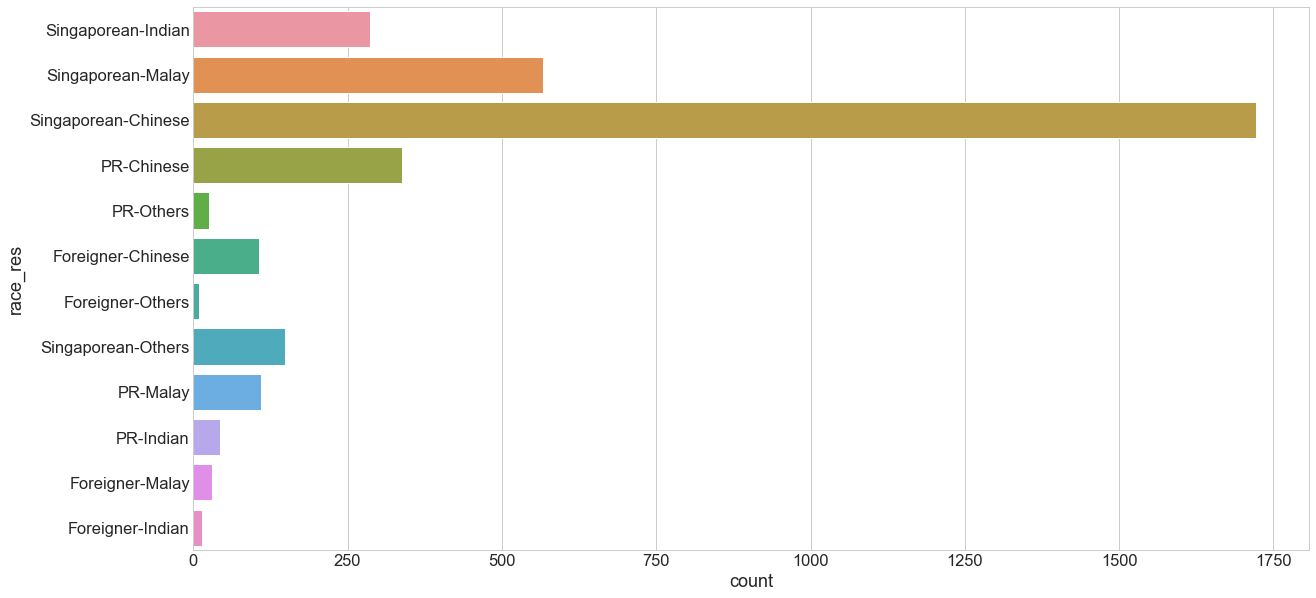

In [124]:
# Combine race and resident_status into 1 feature

data_clean['race_res'] = data_clean['resident_status'] +'-'+ data_clean['race']
fig = plt.figure(figsize=(20,10)) 
sns.countplot(y="race_res", data=data_clean)

##  Clinical Features - Categorical

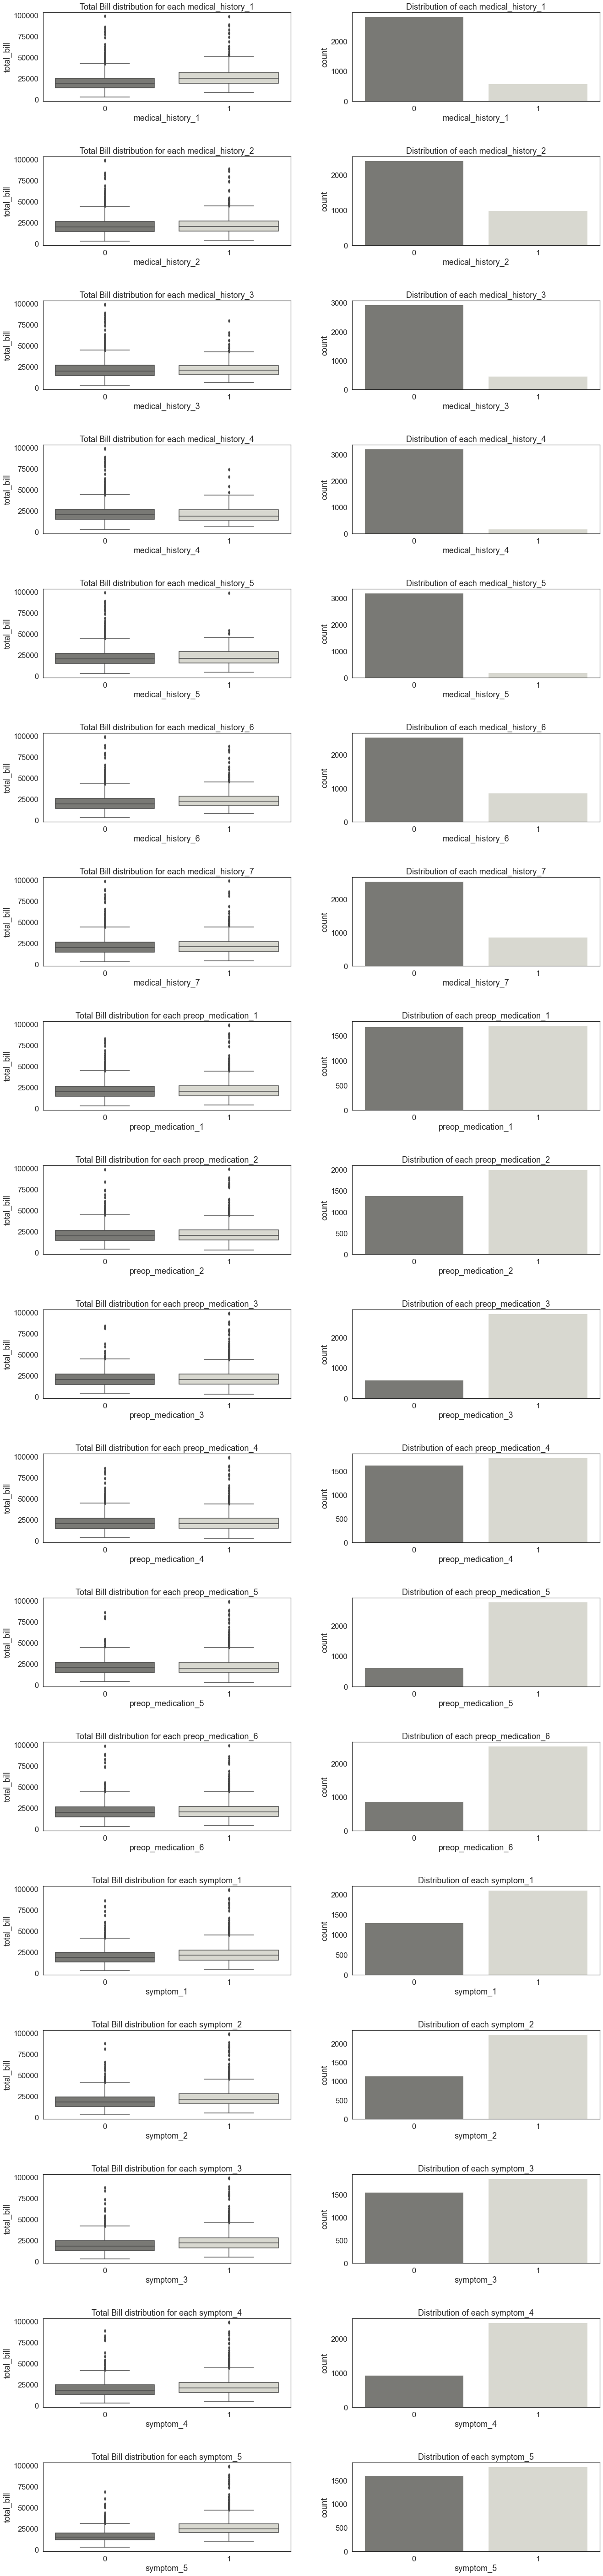

In [181]:
fig, axs = plt.subplots(len(clin_cols),2, figsize=(20,80))
fig.tight_layout(pad=5)

for i , col in enumerate(clin_cols):
    chart = sns.boxplot(x= col, data=data_clean, y='total_bill',ax=axs[i,0]);
    chart.set_title(f'Total Bill distribution for each {col}')
    chart1 = sns.countplot(x= col, data=data_clean,ax=axs[i,1]);
    chart1.set_title(f'Distribution of each {col}')
plt.savefig('clinical_cat.png')    

## Observations

Visually, the clinical features that seem to have the most differences in total bill are:

- Medical History 1
- Symptom 5

Medical histories seem to have quite low incidence  
Symptoms are experienced by majority of patients   
Medications taken by majority of patients  

## Clinical Features - Numerical

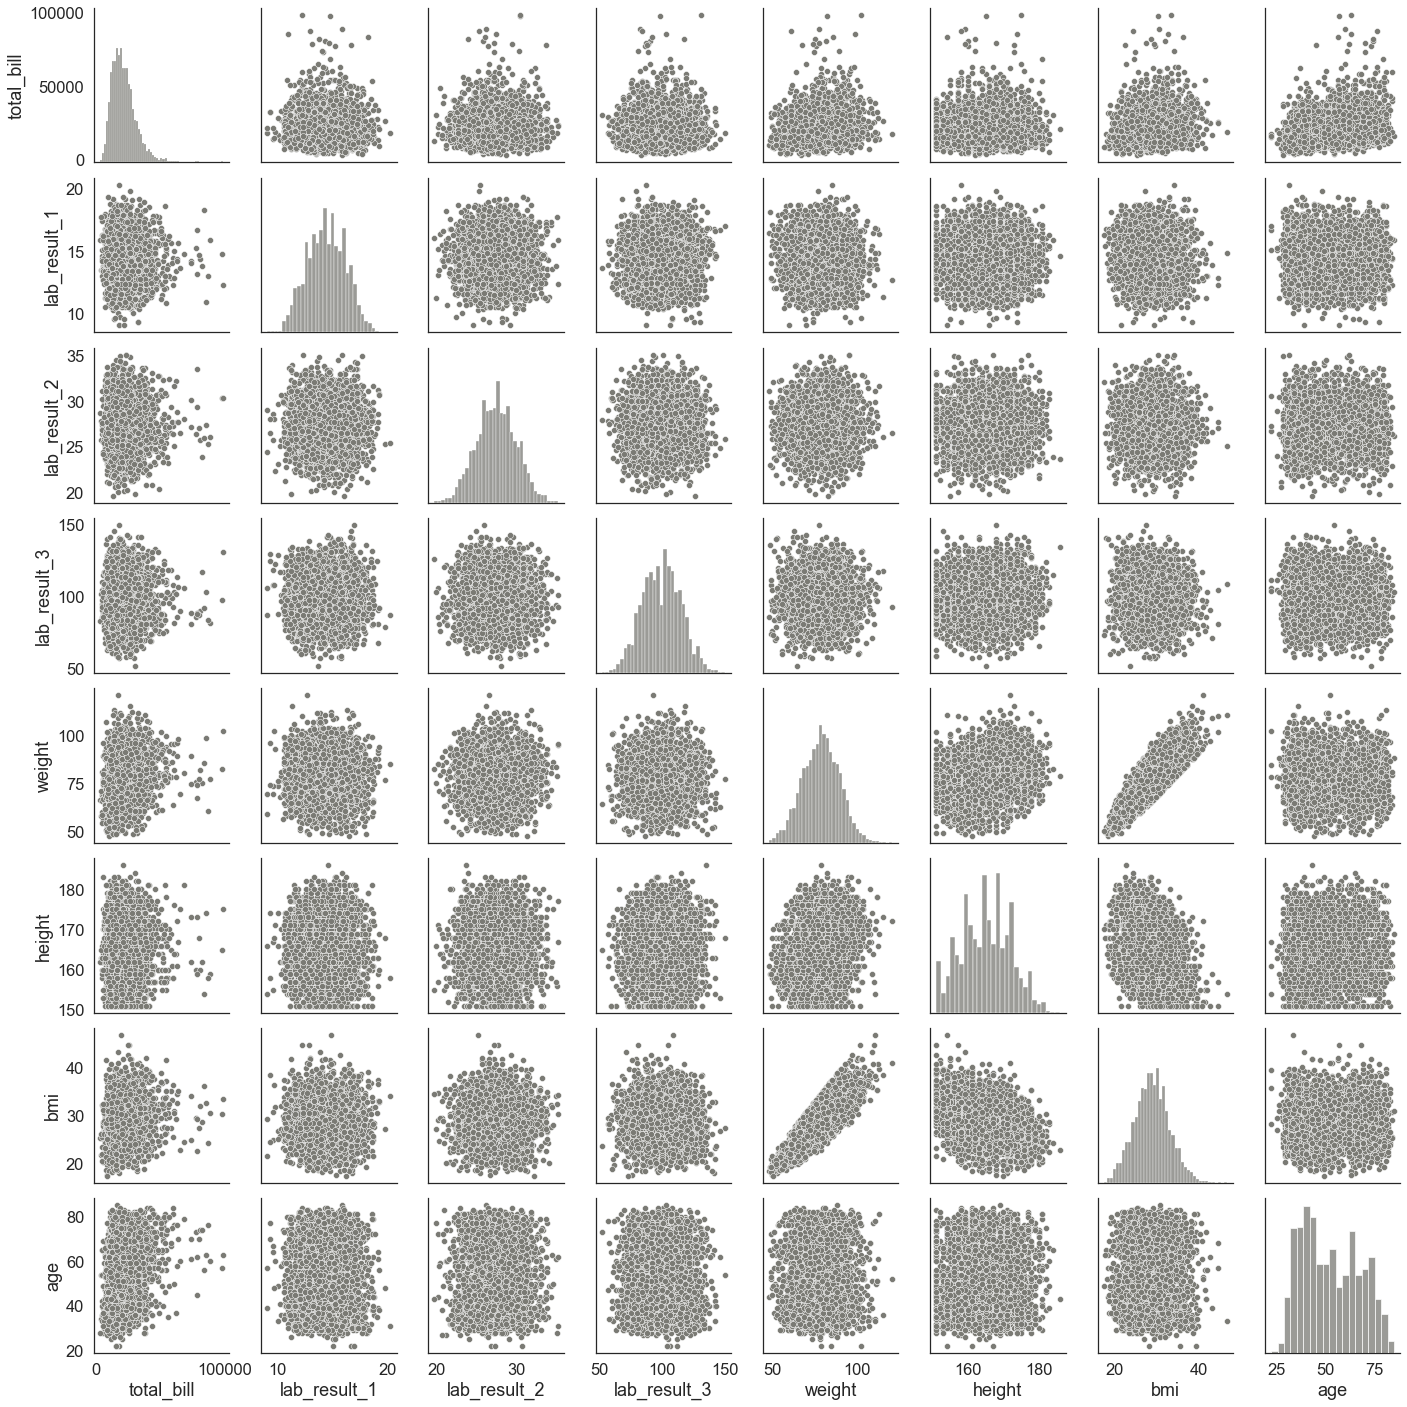

In [182]:
# Plot distributions for numerical data
sns.pairplot(num_data)
plt.savefig('pairplot.png')

## Observations:

### Lab Results

Lab results roughly approximate normal distribution (low kurtosis and skew)  
Total bill has a somewhat parabolic relationship with lab results, with higher amounts near central values of lab results  

### Weight, Height & BMI 

Most of the patients are overweight (bmi > 25) , IQR (26-31)  
The condition may be related to obesity, however higher bill amounts tend to be near central values of weight and BMI

### Age  

Patients are all adults over 25.  
Condition seems to affect more patients ~aged 35 to 45  
Total bill amounts show a mild postive correaltion with age  

## 6) Encode Categorical Features

In preparation for plotting correlation matrix and feature importance.  
Encode categorical features into numerical format that can be processed.

Meanwhile, remove irrelavent features with replicated info. For example:
- race and resident_status very similar to race_res
- patient_id doesn't contain very useful info, also hard to encode due to high cardinality
- date_of_birth very similar to age, also datetime format is not ideal


In [135]:
# Remove irrelavent features with not so usefull or replicated info

drop_cols = ['patient_id','race','resident_status','date_of_birth']
df_enc = data_clean.drop(drop_cols,axis=1)

In [144]:
# One Hot Encode categorical features
enc_cols = ['gender','race_res']
data_enc = pd.get_dummies(df_enc, columns=enc_cols)

# Drop one column of gender and rename
data_Enc = data_enc.drop('gender_Female',axis=1)
data_Enc = data_Enc.rename(columns={'gender_Male': 'gender'})
data_Enc.info()

# Don't drop 1 feature from race_res for understandibilty of feature importance 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 0 to 13596
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   medical_history_1             3400 non-null   int64  
 1   medical_history_2             3400 non-null   int64  
 2   medical_history_3             3400 non-null   int64  
 3   medical_history_4             3400 non-null   int64  
 4   medical_history_5             3400 non-null   int64  
 5   medical_history_6             3400 non-null   int64  
 6   medical_history_7             3400 non-null   int64  
 7   preop_medication_1            3400 non-null   int64  
 8   preop_medication_2            3400 non-null   int64  
 9   preop_medication_3            3400 non-null   int64  
 10  preop_medication_4            3400 non-null   int64  
 11  preop_medication_5            3400 non-null   int64  
 12  preop_medication_6            3400 non-null   int64  
 13  sy

# 6) Feature Correlation

Identity feature correlations especially risk factors that might incur higher cost

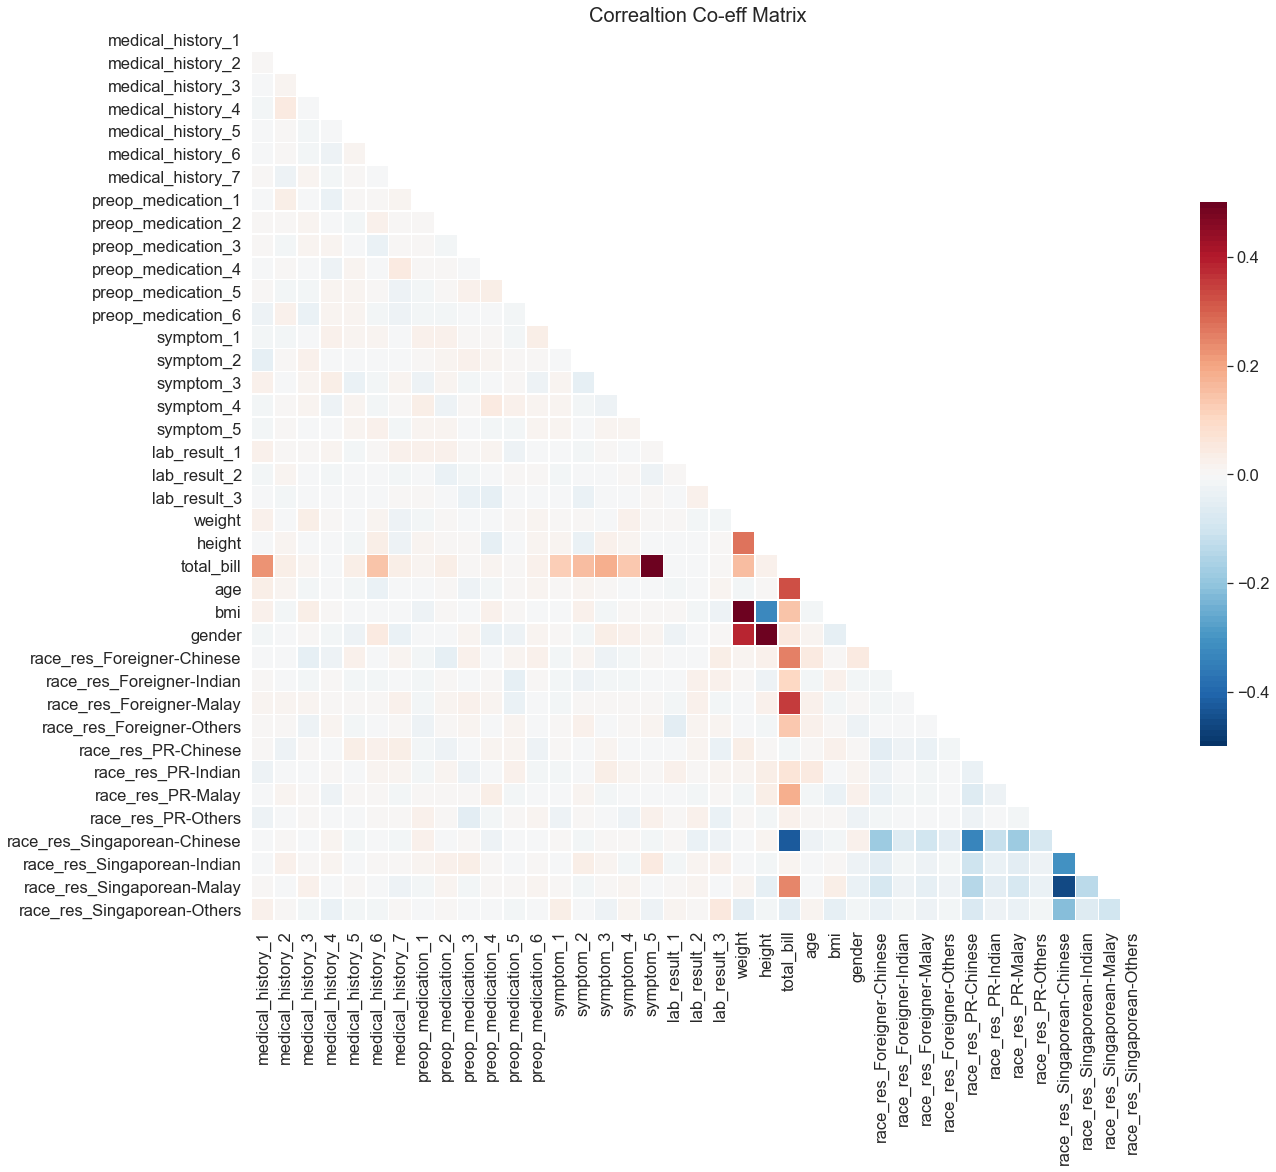

In [183]:
plt.figure(figsize=(20,20))
cor = data_Enc.corr()
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor,vmin=-0.5, vmax=0.5,mask=mask,linewidths=.5, cbar_kws={"shrink": .5},square=True, cmap=sns.color_palette("RdBu_r", 100))
plt.title('Correaltion Co-eff Matrix',fontsize=20);
plt.savefig('corr.png')

In [162]:
#Correlation with output variable
cor_target = abs(cor["total_bill"])
#Selecting correlated features
relevant_features = cor_target[cor_target > 0.20]
print("Top features correlated with Total Bill amount:")
relevant_features.sort_values(ascending=False)

Top features correlated with Total Bill amount:


total_bill                      1.000000
symptom_5                       0.516790
race_res_Singaporean-Chinese    0.426694
race_res_Foreigner-Malay        0.356044
age                             0.325358
race_res_Foreigner-Chinese      0.257177
race_res_Singaporean-Malay      0.244074
medical_history_1               0.226518
Name: total_bill, dtype: float64

## Observations:

Features with higher linear correlation with total bill corroborate features identified with visualizations

# 7) Feature Importance using Random Forest Model


## Feature Importance

### Top Features explaining Total Bill amounts:

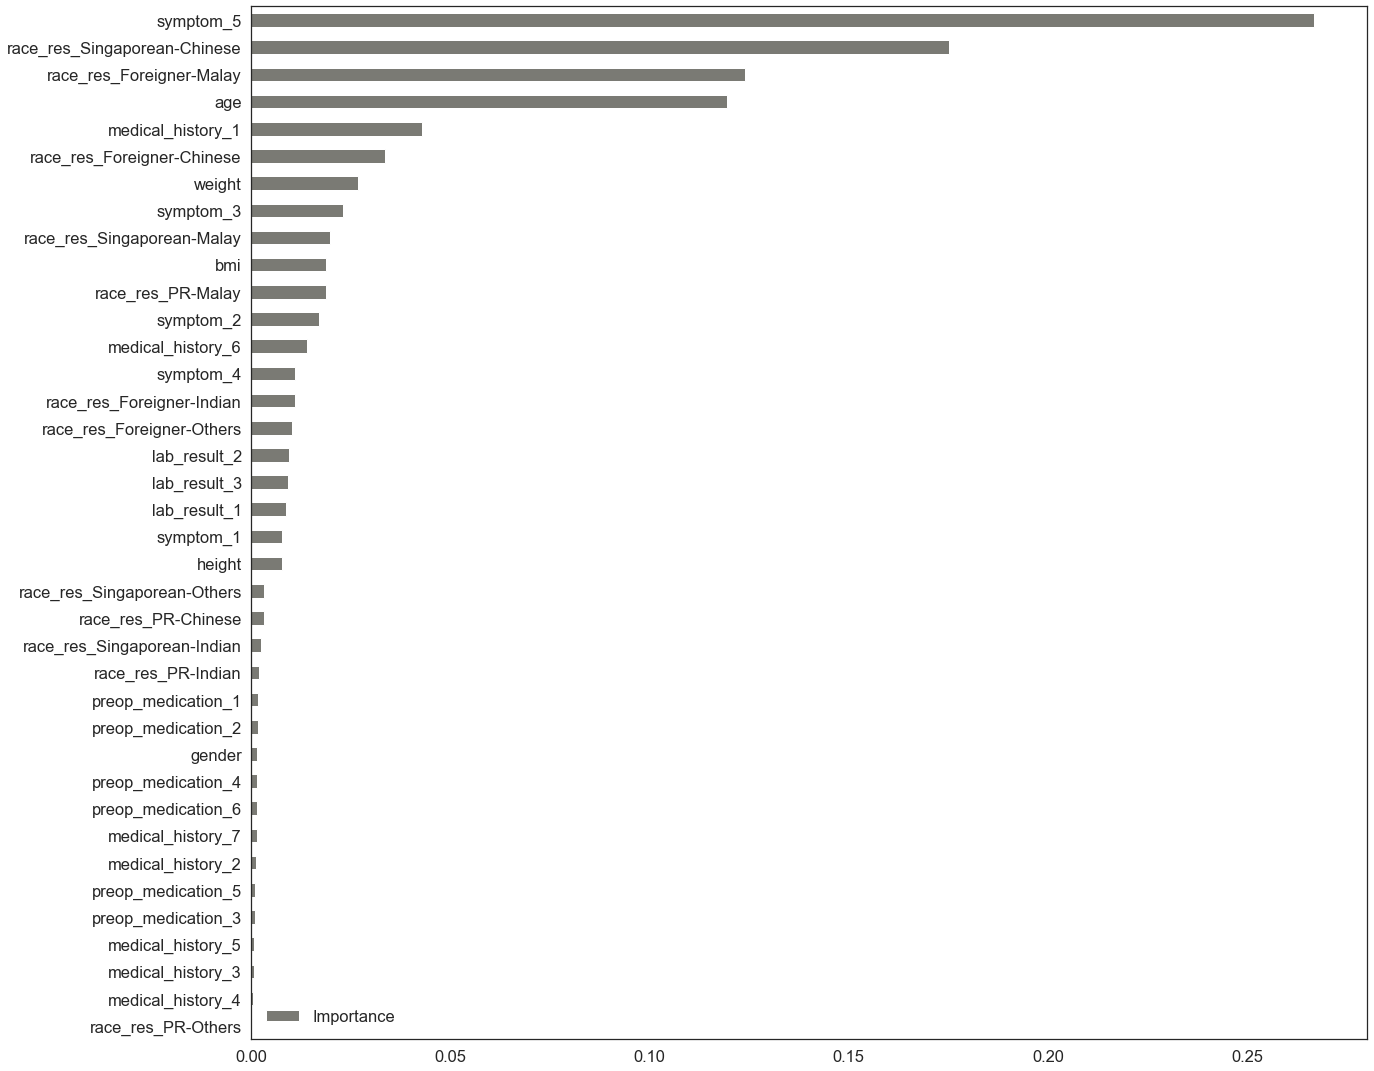

In [202]:
# Using Random Forest to gain an insight on Feature Importance
from sklearn.ensemble import RandomForestRegressor
#full_data_enc.drop('patient_id', axis=1,inplace=True)
clf = RandomForestRegressor()
clf.fit(data_Enc.drop('total_bill', axis=1), data_Enc['total_bill'])

plt.style.use('seaborn-ticks')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=data_Enc.drop('total_bill', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));
plt.savefig('feat_impt.png')

In [167]:
print(importance.sort_values(by='Importance', ascending=False).head(8).sum())
importance.sort_values(by='Importance', ascending=False).head(8)

Importance    0.809938
dtype: float64


Importance
symptom_5                       0.269024
race_res_Singaporean-Chinese    0.177674
age                             0.119340
race_res_Foreigner-Malay        0.118849
medical_history_1               0.043293
race_res_Foreigner-Chinese      0.032302
weight                          0.026582
symptom_3                       0.022873

## Observations:

The Top 8 Features that account for 80% explainability of total bill amount can be summarized by the following features:  

Symptom 5  
Age  
Medical History 1  
Weight  
Symptom 3  
Race
Resident Status

# Appendix

## Relationship between Total Bill and Individual Bill 

From the total_bill vs amount scatter plot, it seems like theres a few clusters.   
I want to find out if clusters relate to any of the signficant features identified

In [195]:
agg_data = df.copy()
agg_data= agg_data.groupby(['patient_id','date_of_admission']).agg({'amount':'sum'}).sort_values(by='date_of_admission')
agg_data = agg_data.rename(columns={'amount':'total_bill'})
data_df = pd.merge(df,agg_data, how='left', on=['patient_id','date_of_admission']).sort_values(by=['date_of_admission','patient_id'])
data_df['age'] = data_df['date_of_admission'].dt.year - data_df['date_of_birth'].dt.year

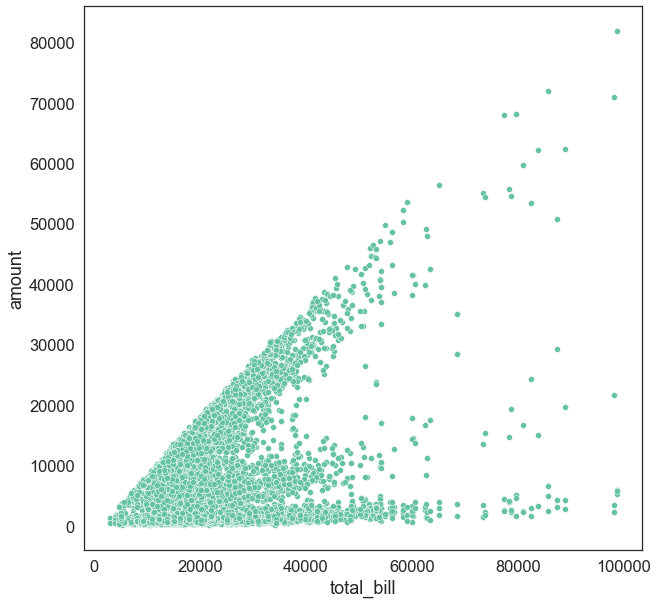

In [192]:
sns.set_palette(sns.color_palette("Set2"))
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=data_df, x="total_bill", y="amount")
plt.savefig('totalbill_indiv.png')

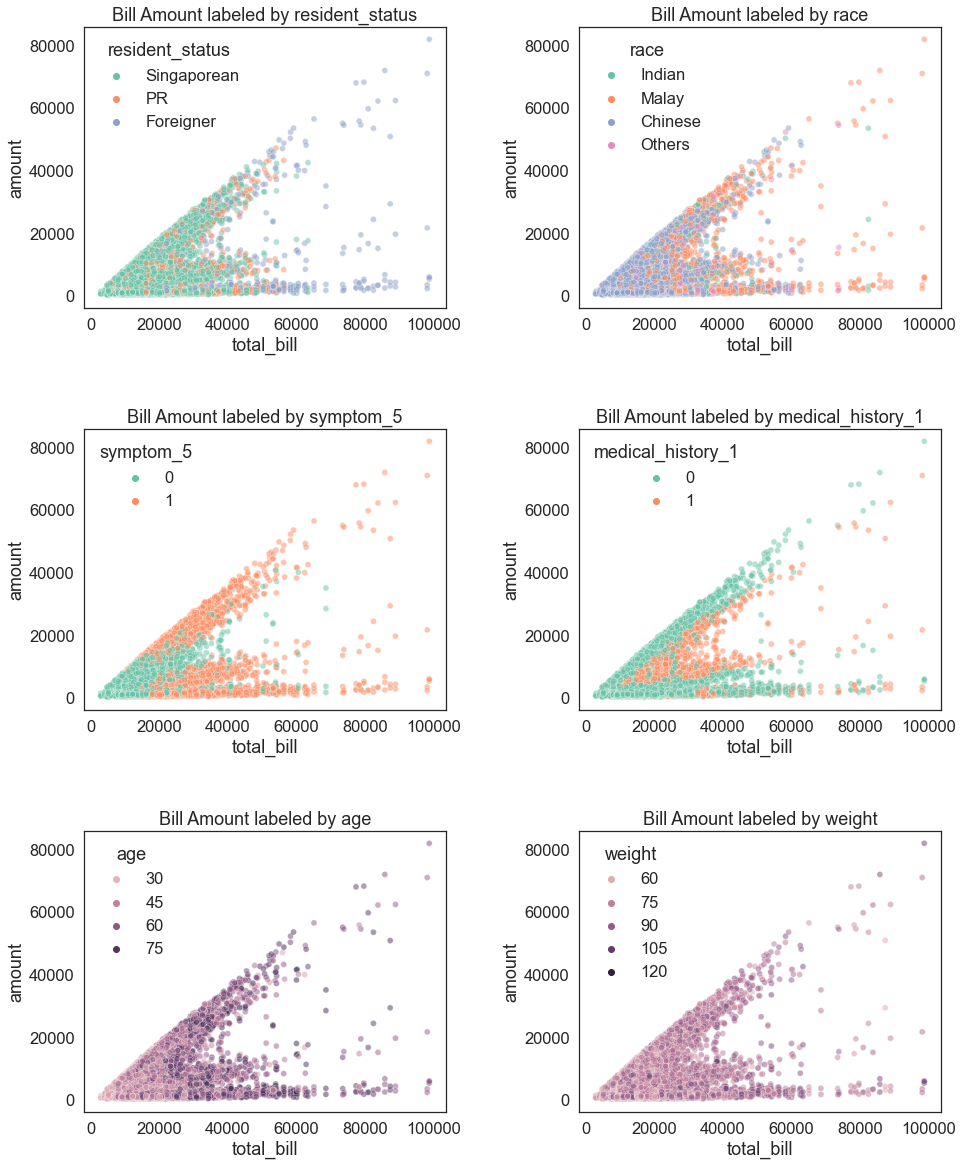

In [199]:
significant_feats = ['resident_status','race','symptom_5','medical_history_1','age','weight']

plt.style.use('seaborn-ticks')
fig, axs = plt.subplots( (len(significant_feats)//2) , 2,figsize=(15,len(significant_feats)*3))
fig.tight_layout(pad=5)

for i , col in enumerate(significant_feats):
    chart = sns.scatterplot(data=data_df, x="total_bill", y="amount", hue=col, ax = axs[i//2, i%2], alpha=0.5)
    chart.set_title(f'Bill Amount labeled by {col}')
plt.savefig('totalbill_label.png')

## Observations:

- Distinct clusters can be seen when labeled with symptom 5 and medical_history_1
- Highest bills are paid by malay foreigners with symptom_5